# Calculate annual, surface type specific fluxes for N<sub>2</sub>O and CH<sub>4</sub>

We are going to calculate st specific flux at different temperatures, two figures one with each st in different sub panel one with everything in one plot

In [1]:
import pandas as pd
from dotenv import load_dotenv; load_dotenv()
from datetime import datetime, timedelta
import os

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib as mpl
import xarray as xr

from utils import load_Ran_ec_data, load_Ran_biomet_data

from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.special import gamma

from sklearn.metrics import r2_score

import statsmodels.api as sm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pickle
import cloudpickle

import pymc as pm
import arviz as az

import seaborn as sns

from py_markdown_table.markdown_table import markdown_table

%matplotlib widget
%load_ext autoreload
%autoreload 2

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_context('paper')

# Define full model function

The model is

$$
\ln{F_{i,k}} = \alpha_k + \beta_k f(T_{i}) + \sum_{j=1}^{N} \gamma_{j,k}x_{i,j} + \delta_{j,k} x_{i,j} f(T_{i}) \\
$$
where

$$
\begin{align*}
i &= 1 \ldots M (\text{\# observations}) \\
k &\in \left[  \mathrm{N_2O} ; \mathrm{CH_4} \right] \\
T_i &= \text{ Observed air temperature (K)} \\
j &= 1 \ldots N (\text{\# surface types}) \\
x_{i,j} &= \text{ Contribution from surface type j to the flux footprint } \mathrm{( \% )} \\
f(T_{i}) &= \frac{T_{i,j} - 10^{\circ} \text{C}}{10^{\circ} \text{C}}
\end{align*}
$$

In [3]:
full_model_eq_x1 = lambda T,params: (params['alpha'] + params['gamma']) + (params['beta']+params['delta'])*((T-10)/10)

# Load best models

In [4]:
with open('models/full_model_n2o_st9_mutable.pkl','rb') as buff:
    model_n2o = cloudpickle.load(buff)

with open('models/full_model_ch4_st6_mutable.pkl','rb') as buff:
    model_ch4 = cloudpickle.load(buff)

# Load measured data

In [5]:
data_n2o = pd.read_csv('data/inference_data_n2o.csv', index_col='time')
data_n2o.index = pd.to_datetime(data_n2o.index)

data_ch4 = pd.read_csv('data/inference_data_ch4.csv', index_col='time')
data_ch4.index = pd.to_datetime(data_ch4.index)

In [6]:
# For CH4 remove the two datapoints as this makes the model comparison difficult

# data_ch4 = data_ch4.loc[data_ch4.F_CH4_ln > 4.1, :]

# Load prediction

In [7]:
pred_n2o = xr.open_dataset('data/n2o_pred_T_response.nc')
pred_ch4 = xr.open_dataset('data/ch4_pred_T_response.nc')

In [8]:
pred_n2o_tair = xr.open_dataset('data/annual_st_n2o.nc')
pred_ch4_tair = xr.open_dataset('data/annual_st_ch4.nc')

# Define surface types

In [9]:
soil_classes = pred_n2o.soil_classes.to_numpy()

# Figure showing surface type fluxes as a function of T<sub>air</sub>

## HDI parameter ranges

In [10]:
n2o_hdi = az.hdi(pred_n2o,var_names=["pred_real_bias_corrected"], hdi_prob = 0.95)
ch4_hdi = az.hdi(pred_ch4,var_names=["pred_real_bias_corrected"], hdi_prob = 0.95)

## Figure

In [11]:
n2o_hdi= az.hdi(pred_n2o,var_names=["pred_real_bias_corrected"], hdi_prob = 0.95)
ch4_hdi = az.hdi(pred_ch4,var_names=["pred_real_bias_corrected"], hdi_prob = 0.95)

In [12]:
medians_n2o = pred_n2o.pred_real_bias_corrected.median(dim=['chain','draw'])
#all_medians_n2o = pred_n2o.pred_real_bias_corrected.median(dim=['chain','draw','Tair'])
#ind_n2o = np.flip(np.argsort(all_medians_n2o)).data

## Sort subplots according to 75th percentile

In [13]:
# Q3_n2o = pred_n2o.pred_real_bias_corrected.quantile(0.75, dim=['chain','draw'])
all_Q3_n2o = pred_n2o.pred_real_bias_corrected.quantile(0.75, dim=['chain','draw','Tair'])
ind_n2o = np.flip(np.argsort(all_Q3_n2o)).data

In [14]:
ind_n2o

array([7, 8, 3, 0, 4, 2, 6, 5, 1])

In [15]:
colors_sitemap = np.array([[70,70,70],
[189,189,189],
[164,114,20],
[223,196,134],
[161,217,155],
[69,193,90],
[31,120,180],
[9,129,1],
[166,206,227]])/256

In [16]:
# new_soil_classes = np.array(['Dead wood','Harvest residue','Exposed peat','Litter', 'Bottom layer (mosses)','Field layer','Ditch (water surface)', 'Living tree','Plant covered ditch'])

In [17]:
n2o_hdi.soil_classes.data

array(['Dead wood', 'Harvest residue', 'Exposed peat', 'Litter',
       'Bottom layer (mosses)', 'Field layer', 'Ditch (water surface)',
       'Living tree', 'Plant covered ditch'], dtype='<U21')

In [18]:
ylims_max = np.array([1, 10, 100, 1000])

np.argmax(ylims_max > 12.5)

2

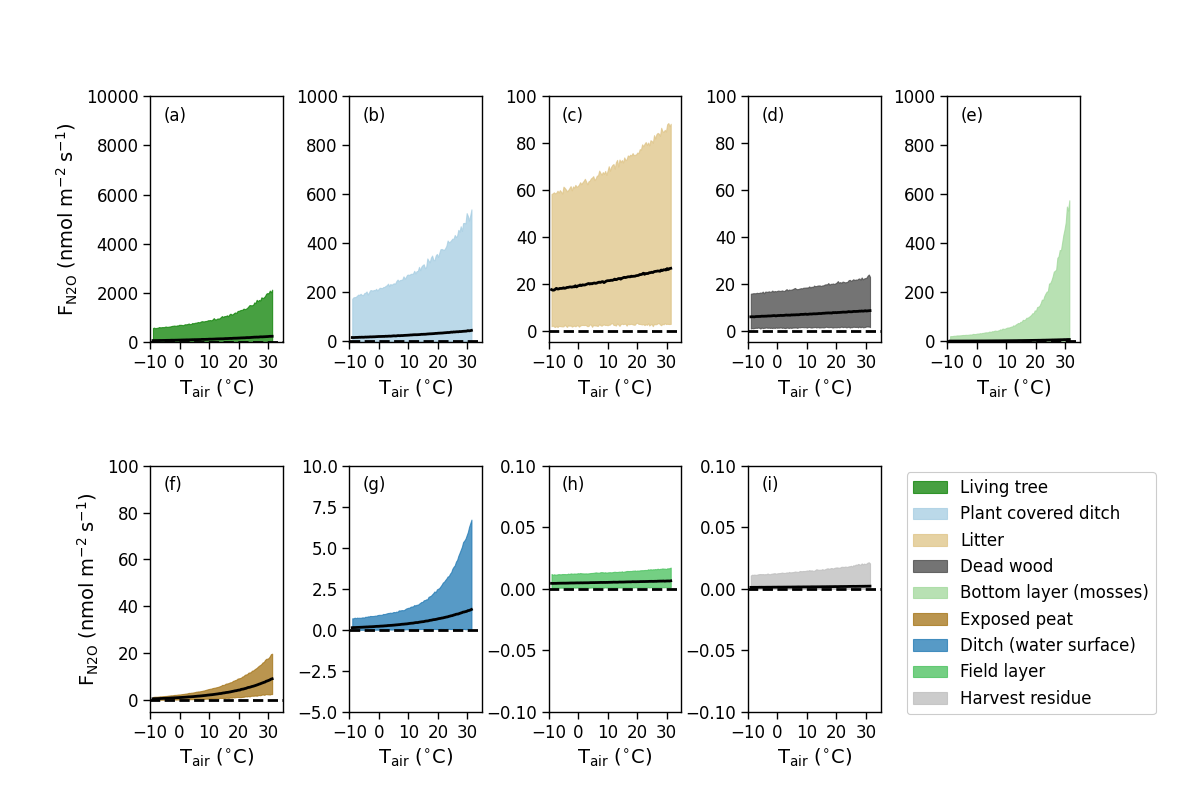

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))
axs = axs.flatten()
fig.subplots_adjust(wspace=0.5, hspace=0.5)
T = n2o_hdi.Tair.values
pp = model_n2o['map'].copy()
idata = model_n2o['model_res'].copy()

st_n2o = soil_classes
st_ch4 = soil_classes

fs = 14
ls = 12
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
# subplot_label_y_space = [1.5, 1.5, 43, 260, 26, 1.5, 4400, 8.4, 175]
# ylims = [[-2, 2], [-2, 2], [-2, 20], [-7, 300],
#          [-2, 30], [-2, 2], [-7, 5000], [-2, 10], [-7, 200]]

ylims_max = np.array([0.001, 0.1, 1, 10, 100, 1000, 10000])
for j, st in enumerate(st_n2o):

    #pp['gamma'] = np.array(model_n2o['map']['gamma'][j])
    #pp['delta'] = np.array(model_n2o['map']['delta'][j])

    # st_specific_flux = (np.exp(full_model_eq_x1(T, pp)) - 0.001)*1000

    upper_st_specific_flux = n2o_hdi.pred_real_bias_corrected[:, ind_n2o[j], 1]

    lower_st_specific_flux = n2o_hdi.pred_real_bias_corrected[:, ind_n2o[j], 0]

    axs[j].fill_between(T, upper_st_specific_flux, lower_st_specific_flux, color=colors_sitemap[ind_n2o[j], :], alpha=0.75, label=n2o_hdi.soil_classes.data[ind_n2o[j]])
    axs[j].plot(T, medians_n2o[:, ind_n2o[j]], 'k-', linewidth=2)
    # axs[j].plot(T, st_specific_flux, linestyle='-', color=cmap[j, :], label=st, linewidth=3)
    axs[j].plot((-20, 50), (0, 0), '--', linewidth=2, color='k')

    # handels, labels = axs[0].get_legend_handles_labels()
    # labels = [labels[1], labels[0], labels[3], labels[2], labels[4]]
    # handels = [handels[1], handels[0], handels[3], handels[2], handels[4]]
    # axs[0].legend(handels, labels, loc='best', fontsize=fs)
    axs[j].tick_params(axis='both', labelsize=ls)
    ymin, ymax = axs[j].get_ylim()
    ymax = ylims_max[np.argmax(ylims_max >= ymax)]
    ymin = -5 if ymax > 1 else -ymax
    axs[j].set_ylim((ymin, ymax))
    #axs[j].set_ylim(ylims[ind_n2o[j]])
    if j == 0 or j == 5:
        axs[j].set_ylabel(
            'F$_{\mathrm{N2O}}$ ($\mathrm{nmol \; m^{-2} \; s^{-1}}$)', fontsize=fs)
    # axs[j].set_yticks(np.linspace(-5,145,16))
    ylim_current = axs[j].get_ylim()
    axs[j].text(0.1, 0.9, subplot_labels[j],
                fontsize=ls, transform=axs[j].transAxes)
    axs[j].set_xlim([-10, 35])
    axs[j].set_xlabel('T$_{\mathrm{air}}$ ($^{\circ}$C)', fontsize=fs)
    axs[j].set_xticks([-10, 0, 10, 20, 30])
    # secax = axs[j].secondary_xaxis('top', functions=(
    #     lambda x: x-273.15, lambda x: x+273.15))
    # secax.set_xlabel('T$_{\mathrm{air}}$ ($^{\circ}$C)', fontsize=fs)
    # secax.tick_params(axis='both', labelsize=ls)
    # secax.set_xticks([-10, 0, 10, 20, 30])

axs[-1].remove()
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=[
           0.87, 0.42, 0.1, 0.0], framealpha=1, fontsize=ls)

## Define new function for blending two colors

In [20]:
a = np.array([1,2,3])
b = np.array([2,9,2])

np.mean([a,b], axis=0)

array([1.5, 5.5, 2.5])

In [21]:
def combine_colors(color1, color2) -> np.ndarray:
    return np.mean([color1, color2], axis=0)*256

In [22]:
# Print colors and copypaste below to avoid concatenation

#dead wood and residue
print(combine_colors(colors_sitemap[0, :], colors_sitemap[1, :]))

#Field layer and trees
print(combine_colors(colors_sitemap[5, :], colors_sitemap[7, :]))


[129.5 129.5 129.5]
[ 39.  161.   45.5]


In [23]:
colors_sitemap_st_6 = np.array([[164, 114, 20],
                               [31, 120, 180],
                               [166, 206, 227],
                               [129.5, 129.5, 129.5],
                               [223, 196, 134],
                               [39.,  161.,   45.5]
                               ])/256

In [24]:
medians_ch4 = pred_ch4.pred_real_bias_corrected.median(dim=['chain','draw'])
all_medians_ch4 = pred_ch4.pred_real_bias_corrected.median(dim=['chain','draw','Tair'])
#ind_ch4 = np.flip(np.argsort(all_medians_ch4)).data

In [25]:
# Q3_ch4 = pred_ch4.pred_real_bias_corrected.quantile(0.75, dim=['chain','draw'])
all_Q3_ch4 = pred_ch4.pred_real_bias_corrected.quantile(0.75, dim=['chain','draw','Tair'])
ind_ch4 = np.flip(np.argsort(all_Q3_ch4)).data

In [26]:
ind_ch4

array([2, 0, 4, 1, 5, 3])

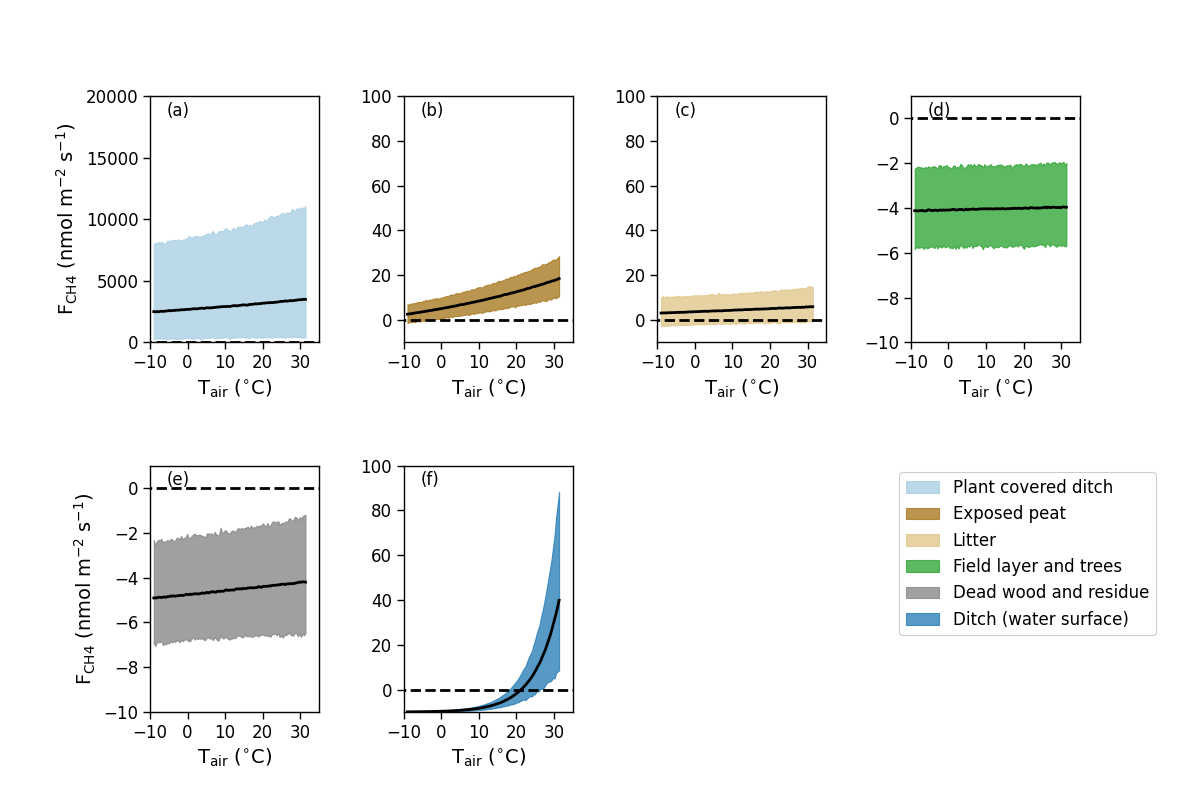

In [54]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
axs = axs.flatten()
fig.subplots_adjust(wspace=0.5, hspace=0.5)
T = ch4_hdi.Tair.values
pp = model_ch4['map'].copy()
idata = model_ch4['model_res'].copy()

st_ch4 = ch4_hdi.soil_classes.data

fs = 14
ls = 12
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
# subplot_label_y_space = [1.5, 1.5, 43, 260, 26, 1.5, 4400, 8.4, 175]
# ylims = [[-10, 10],[-20,20],[-5, 20],[-15,10],[-40,5],[-15, 10],[-50, 400],[-10, 50], [-5, 150]]
ylims_max = np.array([1, 10, 100, 1000, 20000])
for j, st in enumerate(st_ch4):
    # pp['gamma'] = np.array(model_ch4['map']['gamma'][j])
    # pp['delta'] = np.array(model_ch4['map']['delta'][j])

    # st_specific_flux = (np.exp(full_model_eq_x1(T, pp)) - 0.001)*1000

    upper_st_specific_flux = ch4_hdi.pred_real_bias_corrected[:, ind_ch4[j], 1]

    lower_st_specific_flux = ch4_hdi.pred_real_bias_corrected[:, ind_ch4[j], 0]

    axs[j].fill_between(T, upper_st_specific_flux, lower_st_specific_flux,
                        color=colors_sitemap_st_6[ind_ch4[j], :], alpha=0.75, label=ch4_hdi.soil_classes.data[ind_ch4[j]])
    axs[j].plot(T, medians_ch4[:, ind_ch4[j]], 'k-', linewidth=2)
    # axs[j].plot(T, st_specific_flux, linestyle='-', color=cmap[j, :], label=st, linewidth=3)
    axs[j].plot((-20, 40), (0, 0), '--', linewidth=2, color='k')

    # handels, labels = axs[0].get_legend_handles_labels()
    # labels = [labels[1], labels[0], labels[3], labels[2], labels[4]]
    # handels = [handels[1], handels[0], handels[3], handels[2], handels[4]]
    # axs[0].legend(handels, labels, loc='best', fontsize=fs)
    axs[j].tick_params(axis='both', labelsize=ls)
    ymin, ymax = axs[j].get_ylim()
    ymax = ylims_max[np.argmax(ylims_max >= ymax)]
    ymin = -10 if ymax > 1 else -ymax*10
    axs[j].set_ylim((ymin, ymax))
    if j == 0 or j == 4:
        axs[j].set_ylabel(
            'F$_{\mathrm{CH4}}$ ($\mathrm{nmol \; m^{-2} \; s^{-1}}$)', fontsize=fs)
    # axs[j].set_yticks(np.linspace(-5,145,16))
    ylim_current = axs[j].get_ylim()
    axs[j].text(0.1, 0.92, subplot_labels[j],
                fontsize=ls, transform=axs[j].transAxes)
    axs[j].set_xlim([-10, 35])
    axs[j].set_xlabel('T$_{\mathrm{air}}$ ($^{\circ}$C)', fontsize=fs)
    axs[j].set_xticks([-10, 0, 10, 20, 30])
    # secax = axs[j].secondary_xaxis('top', functions=(
    #     lambda x: x-273.15, lambda x: x+273.15))
    # secax.set_xlabel('T$_{\mathrm{air}}$ ($^{\circ}$C)', fontsize=fs)
    # secax.tick_params(axis='both', labelsize=ls)
    # secax.set_xticks([-10, 0, 10, 20, 30])

axs[-2].remove()
axs[-1].remove()
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=[
           0.87, 0.42, 0.1, 0.0], framealpha=1, fontsize=ls)

# Surface type fluxes as boxplot over the whole temperature range

In [28]:
#new_soil_classes = np.array(['Dead wood',' Harvest\nresidue','Exposed\npeat','Litter', 'Bottom layer\n(mosses)','Field layer','Ditch \n(water surface)', 'Living tree','Plant\ncovered\nditch'])

In [29]:
data_ch4 = np.array([pred_ch4_tair.pred_real_bias_corrected[:, :, :, i].data.flatten() for i in range(6)])
q3 = np.percentile(data_ch4, 75, axis=1)
ind_ch4 = np.flip(np.argsort(q3))
sorted_data_ch4 = data_ch4[ind_ch4, :].T

In [30]:
data_n2o = np.array([pred_n2o_tair.pred_real_bias_corrected[:, :, :, i].data.flatten() for i in range(9)])
q3 = np.percentile(data_n2o, 75, axis=1)
ind_n2o = np.flip(np.argsort(q3))
sorted_data_n2o = data_n2o[ind_n2o, :].T

In [31]:
soil_classes_st_9 = list(pred_n2o.soil_classes.data)
soil_classes_st_6 = list(pred_ch4.soil_classes.data)

In [32]:
soil_classes_st_6[3] = 'Dead wood\nand residue'
soil_classes_st_6[5] = 'Field layer\nand trees'

In [33]:
soil_classes_st_9[4] = 'Bottom layer\n(mosses)'
soil_classes_st_9[6] = 'Ditch\n(water surface)'
soil_classes_st_9[8] = 'Plant\ncovered\nditch'

In [34]:
soil_classes_st_6 = np.array(soil_classes_st_6)
soil_classes_st_9 = np.array(soil_classes_st_9)

/var/folders/_7/7fgf24sd5ggbyr5x9kzrwz7c0000gn/T/ipykernel_95326/1990548687.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(yticks0/1000)
/var/folders/_7/7fgf24sd5ggbyr5x9kzrwz7c0000gn/T/ipykernel_95326/1990548687.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(yticks1/1000)


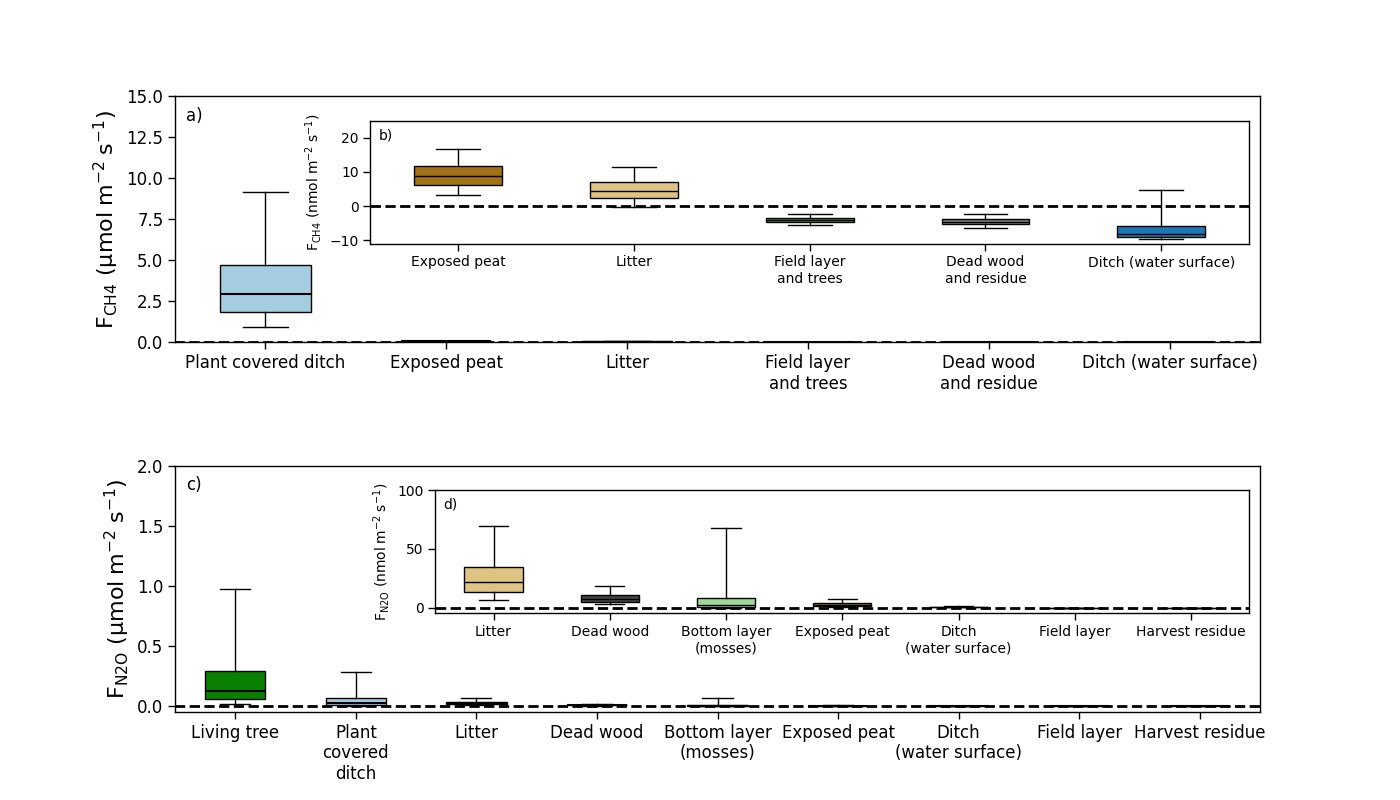

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
axs=axs.flatten()
fig.subplots_adjust(wspace=0.5, hspace=0.5)

ls=12
fs=16

# colors = np.array([cmap(i) for i in np.linspace(0,1,9)])

bplot  = axs[0].boxplot(sorted_data_ch4, showfliers = False, patch_artist=True, whis=(5, 95))
_ = axs[0].set_xticklabels(soil_classes_st_6[ind_ch4])

subfig_bbox0 = [0.18, 0.4, 0.81, 0.5]
box0 = axs[0].get_position()
width0 = box0.width * subfig_bbox0[2]
height0 = box0.height * subfig_bbox0[3]

subax_position = axs[0].transAxes.transform(subfig_bbox0[:2])

subfig_position = fig.transFigure.inverted().transform(subax_position)

x0 = subfig_position[0]
y0 = subfig_position[1]

subax0 = fig.add_axes([x0, y0, width0, height0])

bplot_sub0 = subax0.boxplot(sorted_data_ch4[:, 1:], showfliers=False, patch_artist=True, whis=(5,95))

_ = subax0.set_xticklabels(soil_classes_st_6[ind_ch4[1:]])

subax0.tick_params(axis='both', labelsize=ls-2)

for color_row, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors_sitemap_st_6[ind_ch4[color_row], :])
for i, median in enumerate(bplot['medians']):
    median.set_color('black')
    median.set_linewidth(1.5)

sub_ind_ch4 = ind_ch4[1:]
for color_row, patch in enumerate(bplot_sub0['boxes']):
    patch.set_facecolor(colors_sitemap_st_6[sub_ind_ch4[color_row], :])
for i, median in enumerate(bplot_sub0['medians']):
    median.set_color('black')

_ = axs[0].tick_params(axis='both', labelsize=ls)
axs[0].set_ylabel('F$_{\mathrm{CH4}}$ ($\mathrm{\mu mol \; m^{-2} \; s^{-1}}$)', fontsize=fs)
subax0.set_ylabel('F$_{\mathrm{CH4}}$ ($\mathrm{nmol \; m^{-2} \; s^{-1}}$)', fontsize=fs-6)

bplot1 = axs[1].boxplot(sorted_data_n2o, showfliers = False, patch_artist=True, whis=(5,95))
_ = axs[1].set_xticklabels(soil_classes_st_9[ind_n2o])

subfig_bbox1 = [0.24, 0.4, 0.75, 0.5]
box1 = axs[1].get_position()
width1 = box1.width * subfig_bbox1[2]
height1 = box1.height * subfig_bbox1[3]

subax_position = axs[1].transAxes.transform(subfig_bbox1[:2])

subfig_position = fig.transFigure.inverted().transform(subax_position)

x1 = subfig_position[0]
y1 = subfig_position[1]

subax1 = fig.add_axes([x1, y1, width1, height1])

bplot_sub1 = subax1.boxplot(sorted_data_n2o[:, 2:], showfliers=False, patch_artist=True, whis=(5,95))

_ = subax1.set_xticklabels(soil_classes_st_9[ind_n2o[2:]])

axs[1].tick_params(axis='both', labelsize=ls)

subax1.tick_params(axis='both', labelsize=ls-2)

for color_row, patch in enumerate(bplot1['boxes']):
    patch.set_facecolor(colors_sitemap[ind_n2o[color_row], :])
for i, median in enumerate(bplot1['medians']):
    median.set_color('black')
    median.set_linewidth(1.5)
sub_ind_n2o = ind_n2o[2:]
for color_row, patch in enumerate(bplot_sub1['boxes']):
    patch.set_facecolor(colors_sitemap[sub_ind_n2o[color_row], :])
for i, median in enumerate(bplot_sub1['medians']):
    median.set_color('black')

axs[1].set_ylabel('F$_{\mathrm{N2O}}$ ($\mathrm{\mu mol \; m^{-2} \; s^{-1}}$)', fontsize=fs)

subax1.set_ylabel('F$_{\mathrm{N2O}}$ ($\mathrm{nmol \; m^{-2} \; s^{-1}}$)', fontsize=fs-6)

axs[0].text(0.01, 0.9, '(a)', transform=axs[0].transAxes, fontsize=ls)
axs[1].text(0.01, 0.9, '(c)', transform=axs[1].transAxes, fontsize=ls)
subax0.text(0.01, 0.85, '(b)', transform=subax0.transAxes, fontsize=ls-2)
subax1.text(0.01, 0.85, '(d)', transform=subax1.transAxes, fontsize=ls-2)

axs[0].set_ylim([-50, 15000])
axs[1].set_ylim([-50, 2000])
subax0.set_ylim([-11, 25])
subax1.set_ylim([-5, 100])

yticks0 = axs[0].get_yticks()
axs[0].set_yticklabels(yticks0/1000)

yticks1 = axs[1].get_yticks()
axs[1].set_yticklabels(yticks1/1000)

for ax in [axs[0], axs[1], subax0, subax1]:
    xmin,xmax = ax.get_xlim()
    ax.plot((xmin*0.5, xmax*1.5), (0,0), 'k--', linewidth=2)
    ax.set_xlim((xmin, xmax))

# Calculate annual balance

## Load T<sub>air</sub> data

In [36]:
Tair = pd.read_csv('data/T_air_gapfilled.csv')
Tair.head()

,time,T_air
0,2022-05-01 00:00:00,-0.7717
1,2022-05-01 00:30:00,-1.2116
2,2022-05-01 01:00:00,-1.2247
3,2022-05-01 01:30:00,-1.1864
4,2022-05-01 02:00:00,-0.9068


In [37]:
T = Tair['T_air'].values
T = T.reshape(T.shape[0], 1)

In [38]:
T_air_rolling = Tair.T_air.rolling(window=48).mean()

In [39]:
pd.to_datetime(Tair.time)

0      2022-05-01 00:00:00
1      2022-05-01 00:30:00
2      2022-05-01 01:00:00
3      2022-05-01 01:30:00
4      2022-05-01 02:00:00
               ...        
9548   2022-11-15 22:00:00
9549   2022-11-15 22:30:00
9550   2022-11-15 23:00:00
9551   2022-11-15 23:30:00
9552   2022-11-16 00:00:00
Name: time, Length: 9553, dtype: datetime64[ns]

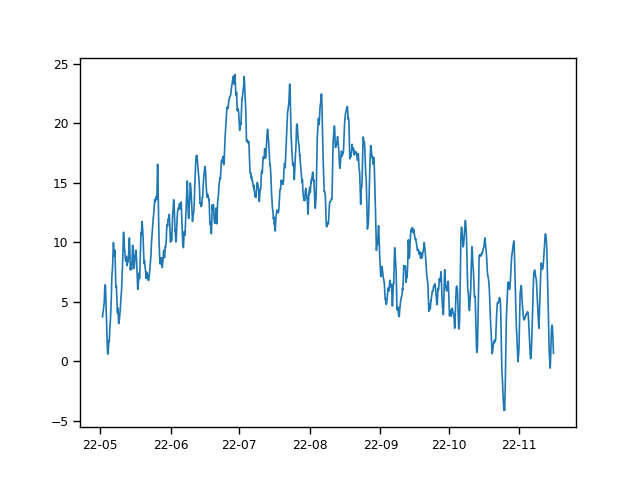

In [40]:
fig, ax = plt.subplots()

ax.plot(pd.to_datetime(Tair.time), T_air_rolling)
#print(ax.get_xticks())
# xticks = [datetime(2022,5,1), datetime(2022,6,1), datetime(2022,7,1), datetime(2022,8,1), datetime(2022,9,1)]
#ax.set_xticks(ax.get_xticks()[::1000])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))

## Draw S samples for each M T<sub>air</sub> data points

Draw NxS samples for
- $\alpha$
- $\beta$
- $\gamma$
- $\delta$
- $\sigma_{\epsilon}$

## Annual balance B<sub>j</sub> for surface type j

$$
B_j = \sum_{i=1}^M E\{F|x_{i,j}=1; T_i\}
$$

for N<sub>2</sub>O

$$
B_j = \sum_{i=1}^S \left[ \exp{\left[(\alpha + \gamma_j) + (\beta + \delta_j)f(T_i) + \mathcal{N}(0, \sigma_e) \right]} - 0.001 \right] \cdot 1800 \cdot 10^{-6}
$$

for CH<sub>4</sub>

$$
B_j = \sum_{i=1}^S \left[ \exp{\left[(\alpha + \gamma_j) + (\beta + \delta_j)f(T_i) + \mathcal{N}(0, \sigma_e) \right]} - 0.033 \right] \cdot 1800 \cdot 10^{-6}
$$

unit of $B_j$ is ($ \mathrm{mol} \; \mathrm{m}^{-2} $). 

The annual balance is calculated S times separately and the mean and standard deviation are returned in the function below.

**The annual balance is calculated here only for the snow free period (1.5.2022-16.11.2022)**


In [41]:
def calculate_annual_budget_map(params, st, Tair, shift):
    F = params['alpha'] + params['gamma'][st] + (params['beta'] + params['delta'][st])*((Tair.flatten() - 283.15)/10)
    B = np.sum((np.exp(F)-shift)*1800*1e-9) # mol/m2
    return B

In [42]:
def calculate_annual_budget(F, shift):
    B = np.sum((np.exp(F)-shift)*1800*1e-9) # mol/m2
    return B

In [43]:
def print_hdi_budgets_n2o_ch4(hdi_n2o, map_params_n2o, hdi_ch4, map_params_ch4, modifier_n2o=1, modifier_ch4=1):
    n2o_budgets_lower = np.array([calculate_annual_budget(hdi_n2o.pred[:, i, 0], 0.0) for i in range(len(hdi_n2o.soil_classes))])*modifier_n2o
    n2o_budgets_higher = np.array([calculate_annual_budget(hdi_n2o.pred[:, i, 1], 0.0) for i in range(len(hdi_n2o.soil_classes))])*modifier_n2o
    n2o_budget_map = np.array([calculate_annual_budget_map(map_params_n2o, i, T, 0.0) for i in range(len(map_params_n2o['gamma']))])*modifier_n2o
    ch4_budgets_lower = np.array([calculate_annual_budget(hdi_ch4.pred[:, i, 0], 10.0) for i in range(len(hdi_ch4.soil_classes))])*modifier_ch4
    ch4_budgets_higher = np.array([calculate_annual_budget(hdi_ch4.pred[:, i, 1], 10.0) for i in range(len(hdi_ch4.soil_classes))])*modifier_ch4
    ch4_budget_map = np.array([calculate_annual_budget_map(map_params_ch4, i, T, 10.0) for i in range(len(map_params_ch4['gamma']))])*modifier_ch4

    n2o_res = {k:f'{np.round(m,5)} ({np.round(s,5)}-{np.round(t,5)})' for k,m,s,t in zip(hdi_n2o.soil_classes.to_numpy(), n2o_budget_map, n2o_budgets_lower, n2o_budgets_higher)}
    ch4_res = {k:f'{np.round(m,5)} ({np.round(s,5)}-{np.round(t,5)})' for k,m,s,t in zip(hdi_ch4.soil_classes.to_numpy(), ch4_budget_map, ch4_budgets_lower, ch4_budgets_higher)}
    items = list(n2o_res.items())
    items.insert(0, ('Flux', 'N2O'))
    n2o_res = dict(items)
    items = list(ch4_res.items())
    items.insert(0, ('Flux', 'CH4'))
    ch4_res = dict(items)

    st_data = [
        n2o_res, ch4_res
    ]
    print(markdown_table(st_data).get_markdown())

    return (n2o_budget_map, n2o_budgets_lower, n2o_budgets_higher, ch4_budget_map, ch4_budgets_lower, ch4_budgets_higher)

## Load st specific annual balance samples

In [44]:
annual_st_n2o = xr.open_dataset('data/annual_st_n2o.nc')
annual_st_ch4 = xr.open_dataset('data/annual_st_ch4.nc')

In [45]:
annual_st_n2o_hdi = az.hdi(annual_st_n2o,var_names=["pred"], hdi_prob = 0.95)
annual_st_ch4_hdi = az.hdi(annual_st_ch4,var_names=["pred"], hdi_prob = 0.95)

In [46]:
annual_st_ch4_hdi

<xarray.Dataset>
Dimensions:       (time: 9553, soil_classes: 6, hdi: 2)
Coordinates:
  * time          (time) datetime64[ns] 2022-05-01 ... 2022-11-16
  * soil_classes  (soil_classes) <U21 'Exposed peat' ... 'Field layer and trees'
  * hdi           (hdi) <U6 'lower' 'higher'
Data variables:
    pred          (time, soil_classes, hdi) float64 2.387 3.004 ... 1.463 2.072

## Calculate annual balance for each surface type

In [47]:
annual_st_n2o_hdi.pred[:, 0, 0].values

array([0.60414173, 0.65682986, 0.67089162, ..., 0.67573903, 0.66502528,
       0.58783902])

In [48]:
n2o_budget_lower = calculate_annual_budget(annual_st_n2o_hdi.pred[:, 0, 0].values, 0.0)

In [49]:
n2o_budgets_lower = np.array([calculate_annual_budget(annual_st_n2o_hdi.pred[:, i, 0], 0.0) for i in range(len(annual_st_n2o.soil_classes))])
n2o_budgets_higher = np.array([calculate_annual_budget(annual_st_n2o_hdi.pred[:, i, 1], 0.0) for i in range(len(annual_st_n2o.soil_classes))])
n2o_budget_map = np.array([calculate_annual_budget_map(model_n2o['map'], i, T, 0.0) for i in range(len(model_n2o['map']['gamma']))])

In [50]:
ch4_budgets_lower = np.array([calculate_annual_budget(annual_st_ch4_hdi.pred[:, i, 0], 10.0) for i in range(len(annual_st_ch4.soil_classes))])
ch4_budgets_higher = np.array([calculate_annual_budget(annual_st_ch4_hdi.pred[:, i, 1], 10.0) for i in range(len(annual_st_ch4.soil_classes))])
ch4_budget_map = np.array([calculate_annual_budget_map(model_ch4['map'], i, T, 10.0) for i in range(len(model_ch4['map']['gamma']))])

In [51]:
n2o_res = {k:f'{np.round(m,5)} ({np.round(s,5)}-{np.round(t,5)}' for k,m,s,t in zip(annual_st_n2o.soil_classes.to_numpy(), n2o_budget_map, n2o_budgets_lower, n2o_budgets_higher)}
ch4_res = {k:f'{np.round(m,5)} ({np.round(s,5)}-{np.round(t,5)}' for k,m,s,t in zip(annual_st_ch4.soil_classes.to_numpy(), ch4_budget_map, ch4_budgets_lower, ch4_budgets_higher)}

In [52]:
_ = print_hdi_budgets_n2o_ch4(annual_st_n2o_hdi, model_n2o['map'], annual_st_ch4_hdi, model_ch4['map'])

KeyError: 'Dead wood and residue'

In [ ]:
model_ch4['map']

{'alpha': array(-3.45501314),
 'beta_log__': array(-9.79439893),
 'gamma_mu': array(0.16527335),
 'gamma': array([ 0.27592115, -0.7238804 ,  2.41352836, -0.227431  ,  0.23254399,
        -0.18636468]),
 'delta_log__': array([-2.63839822, -0.44070559, -5.46317511, -5.3305323 , -7.29409111,
        -9.63683553]),
 'sigma_log__': array(-2.99644662),
 'beta': array(5.57630592e-05),
 'delta': array([7.14756659e-02, 6.43582157e-01, 4.24007167e-03, 4.84149220e-03,
        6.79542275e-04, 6.52793025e-05]),
 'sigma': array(0.0499643)}

## Annual st specific flux but with kg/ha instead

In [ ]:
mod_n2o = 0.044013*1e4 #kg/mol * m2/ha
mod_ch4 = 0.01604*1e4 #kg/mol * m2/ha
_ = print_hdi_budgets_n2o_ch4(annual_st_n2o_hdi, model_n2o['map'], annual_st_ch4_hdi, model_ch4['map'], mod_n2o, mod_ch4)

KeyError: 'Dead wood and residue'

## Annual st specific flux but with kg co2eq / ha instead

In [ ]:
GWP100_n2o = 265 # kgCO2eq / kg N2O

GWP100_ch4 = 28 # kgCO2eq / kg CH4
mod_n2o = 0.044013*1e4*GWP100_n2o #kg/mol * m2/ha * kg CO2 eq / kg N2O
mod_ch4 = 0.01604*1e4*GWP100_ch4 #kg/mol * m2/ha * kg CO2 eq / kg CH4
n2o_budget_map, n2o_budget_lower, n2o_budget_higher, ch4_budget_map, ch4_budget_lower, ch4_budget_higer = \
print_hdi_budgets_n2o_ch4(annual_st_n2o_hdi, model_n2o['map'], annual_st_ch4_hdi, model_ch4['map'], mod_n2o, mod_ch4)


```
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Flux|            Fallen tree            |             Dry branch             |            Exposed peat           |              Light moss              |              Dark moss              |         Green vegetation         |                 Ditch                 |               Tree              |            Covered ditch            |
+----+-----------------------------------+------------------------------------+-----------------------------------+--------------------------------------+-------------------------------------+----------------------------------+---------------------------------------+---------------------------------+---------------

### Areas

Fallen tree: 14744.0 : 22.8% <br>
Dry branch: 5110.0 : 7.9%<br>
Exposed peat: 18732.0 : 29.0%<br>
Light moss: 12854.0 : 19.9%<br>
Dark moss: 917.0 : 1.4%<br>
Green vegetation: 7611.0 : 11.8%<br>
Ditch: 1202.0 : 1.9%<br>
Tree: 2707.0 : 4.2%<br>
Covered ditch: 698.0 : 1.1%<br>
Instruments: 7.0 : 0.0%<br>